#HMNIST Data analysis and CNN prediction model

The notebook aims to analyze Kaggle's Skin Cancer MNIST dataset which contains 10K images of skin cancer localization images and the dataset consists of HAM10000_metadata.csv which contains the metadata for the skin cancer image and data/images directory contains the actual skin cancer images. I'll be doing EDA with seaborn and pandas packages and will be using keras CNN model for cancer prediction 

##EDA of patient metadata

In [1]:
#mount driver with data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Colab notebook has an outdated seaborn module for visualization so let's update it to the latest package

In [2]:
!pip install seaborn==0.9.0

In [0]:
#read data
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import glob

metadata = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/HAM10000_metadata.csv")

In [4]:
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


### Patient Metadata information
* lesion_id: id for the lesion
* image_id: id corresponding to the image file name
* dx: cancer type acronym
* dx_type: how the cancer type was diagnosed
* sex: sex of the patient
* localization: area where the skin cancer image was taken

In [5]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0001863,ISIC_0031119,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


Looks like we are missing some values for age. Let's fill that up with the age median

In [0]:
#fill in missing value
metadata[['age']] = metadata[['age']].fillna(metadata[['age']].median())

In [7]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,10015.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0001863,ISIC_0031119,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.853220,NaN,NaN
std,NaN,NaN,NaN,NaN,16.920833,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


Now, we can see that we have all 10015 entries for all columns

##Visualization for metadata

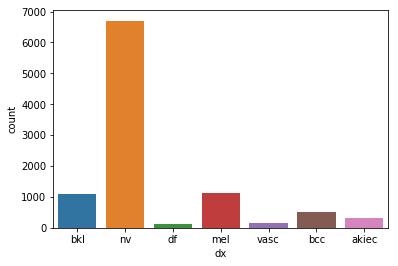

In [8]:
#visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='dx',data=metadata)

We can see that we have a non-even distribution of labels for the data. For better results we may consider over/undersampling for a more even distribution. However, since we only have 10K dataset, let's leave it at here for now.

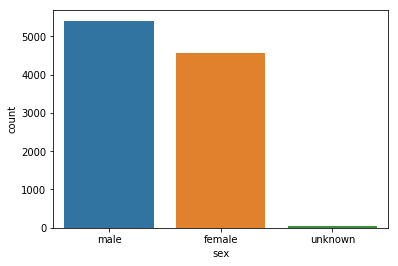

In [9]:
sns.countplot(x='sex',data=metadata)

Looks like we have some 'unknown' sex and we seem to have a slightly more male population in the dataset. Since unknown is such a minor label, let's switch it to male

In [0]:
#replace unknown with male
metadata[['sex']] = metadata[['sex']].replace('unknown','male')

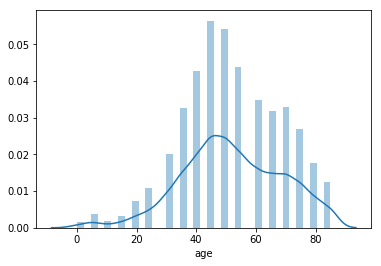

In [11]:
sns.distplot(metadata.loc[:,'age'])

Looks like we have a slightly negatively skewed data. Considering that we are dealing with cancer patient data, 
it's understandable why we have a dense older population.

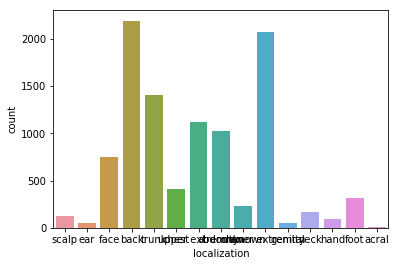

In [12]:
sns.countplot(x='localization',data=metadata)

Seems that most of the cancer localizations were found in the back

In [13]:
#remove lesion_id since image_id will be used
metadata = metadata[['image_id','age','sex','localization','dx']] #remove dx_type since we are purely taking patient metadata
metadata.head(10)

,image_id,age,sex,localization,dx
0,ISIC_0027419,80.0,male,scalp,bkl
1,ISIC_0025030,80.0,male,scalp,bkl
2,ISIC_0026769,80.0,male,scalp,bkl
3,ISIC_0025661,80.0,male,scalp,bkl
4,ISIC_0031633,75.0,male,ear,bkl
5,ISIC_0027850,75.0,male,ear,bkl
6,ISIC_0029176,60.0,male,face,bkl
7,ISIC_0029068,60.0,male,face,bkl
8,ISIC_0025837,70.0,female,back,bkl
9,ISIC_0025209,70.0,female,back,bkl


##Preprocessing cancer images
Since our metadata analysis is complete, let's move on to processing images. This section was commented because processed files are already saved in directory to save time for re-running the notebook

In [14]:
"""
image_list = glob.glob("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/images/*.jpg")
images = []
for image_file in image_list:
  #resize image to 100,75 and flatten image to numpy array
  images.append(np.array(Image.open(image_file).resize((100,75))).flatten())
images = np.matrix(images)
#save in data/ directory
np.save('/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/images.npy',images)
"""

'\nimage_list = glob.glob("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/images/*.jpg")\nimages = []\nfor image_file in image_list:\n  images.append(np.array(Image.open(image_file).resize((100,75))).flatten())\nimages = np.matrix(images)\nnp.save(\'/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/images.npy\',images)\n'

In [0]:
#image_list = glob.glob("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/images/*.jpg")
#images = np.load('/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/images.npy')

In [0]:
#for i in range(len(image_list)):
#  image_list[i] = os.path.basename(image_list[i])

In [17]:
"""
#combine image_data with dataframe
image_data = pd.DataFrame(images,columns=list(range(100*75*3)))
image_data['image_id'] = image_list
image_data.head()
"""

"\nimage_data = pd.DataFrame(images,columns=list(range(100*75*3)))\nimage_data['image_id'] = image_list\nimage_data.head()\n"

In [0]:
#remove extensions to match format with image_id

#image_data['image_id'] = image_data['image_id'].apply(lambda x:os.path.splitext(x)[0])
#image_data.head()

In [19]:
#merge image_data with metadata based on image_id

"""
train_set = pd.merge(image_data,metadata,on='image_id')
train_set.to_csv("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/train_set.csv")
train_set.head()
"""

'\ntrain_set = pd.merge(image_data,metadata,on=\'image_id\')\ntrain_set.to_csv("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/train_set.csv")\ntrain_set.head()\n'

##Preparing the train set
Since we have both our metadata and image_data prepared let's prepare it for the CNN model

In [0]:
#get processed data
train_set = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/HMNIST/data/train_set.csv")

In [21]:
train_set = train_set.drop(columns=['Unnamed: 0']) #remove index column
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,22495,22496,22497,22498,22499,image_id,age,sex,localization,dx
0,175,154,173,174,157,173,174,159,180,175,...,184,186,192,182,190,ISIC_0033323,75.0,male,back,mel
1,167,129,166,173,131,169,176,134,170,171,...,137,169,182,141,173,ISIC_0033332,50.0,male,unknown,nv
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,ISIC_0033331,30.0,female,lower extremity,nv
3,94,75,77,102,81,78,115,97,97,125,...,61,38,103,74,60,ISIC_0033325,60.0,male,chest,mel
4,164,139,168,165,142,168,166,142,166,164,...,134,154,162,133,153,ISIC_0033330,50.0,male,unknown,nv


In [0]:
#drop id column and get labels
train_set = train_set.drop(columns=['image_id'])
labels = train_set.pop('dx')

In [23]:
#one-hot encode all categorical data
train_set = pd.get_dummies(train_set)
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,175,154,173,174,157,173,174,159,180,175,...,0,0,0,0,0,0,0,0,0,0
1,167,129,166,173,131,169,176,134,170,171,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,94,75,77,102,81,78,115,97,97,125,...,0,0,0,0,0,0,0,0,0,0
4,164,139,168,165,142,168,166,142,166,164,...,0,0,0,0,0,0,0,0,1,0


In [24]:
#scale age with RobustScaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
age = train_set["age"].values.reshape(-1, 1)
train_set["age"] = scaler.fit_transform(age)
print(train_set["age"][0:10])

0    1.0
1    0.0
2   -0.8
3    0.4
4    0.0
5    0.4
6    1.4
7    1.4
8    0.2
9    0.4
Name: age, dtype: float64


In [25]:
#normalize image_data from 0~1
train_set = train_set.values
train_set[:,0:100*75*3] = train_set[:,0:100*75*3]/255.0
print(train_set[0:10])

[[0.68627451 0.60392157 0.67843137 ... 0.         0.         0.        ]
 [0.65490196 0.50588235 0.65098039 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.5372549  0.48235294 0.54117647 ... 0.         0.         0.        ]
 [0.51764706 0.48627451 0.54509804 ... 0.         1.         0.        ]
 [0.56862745 0.51764706 0.62745098 ... 0.         0.         1.        ]]


In [26]:
print(labels[0:10])

0    mel
1     nv
2     nv
3    mel
4     nv
5    mel
6    mel
7    bkl
8     nv
9     nv
Name: dx, dtype: object


In [27]:
#one-hot encode labels
labels = pd.get_dummies(labels)
labels = labels.values
print(labels[0:10])

[[0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]]


##Building CNN model for prediction
Now, we have everything prepared, let's build the actual model for classification. In fact, we will use CNN to extract the image features and use a DNN model to use both the metadata and features extracted from CNN for classifiction.

In [28]:
#import keras modules
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, Activation, Reshape, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model

image_input = Input(shape=(100*75*3,),name='image_input')
x = Reshape((100,75,3), input_shape=(100*75*3,))(image_input)
x = Conv2D(70, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(70, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(500, kernel_size=3, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(1024, kernel_size=3, padding="valid")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
image_output = Flatten()(x)

meta_input = Input(shape=(18,),name='meta_input')
#concatenate CNN image features with metadata input
x = keras.layers.concatenate([image_output,meta_input])
x = Dense(units=100)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)
x = Dense(units=100)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)
x = Dense(units=100)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)
x = Dense(units=7)(x)
main_output = Activation("softmax")(x)
     
model = Model(inputs=[image_input,meta_input],outputs=[main_output])
optimizer = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 22500)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 75, 3)   0           image_input[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 75, 70)  1960        reshape_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 75, 70)  280         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_set,labels,test_size=0.2)
X_train_image = X_train[:,0:100*75*3]
X_train_meta = X_train[:,100*75*3:]
X_test_image = X_test[:,0:100*75*3]
X_test_meta = X_test[:,100*75*3:]
history = model.fit([X_train_image,X_train_meta],[y_train],epochs=50, batch_size=64,shuffle=True,validation_data=([X_test_image,X_test_meta], [y_test]))

Train on 8012 samples, validate on 2003 samples
Epoch 1/50
8012/8012 [==============================] - 37s 5ms/step - loss: 2.6632 - acc: 0.1704 - val_loss: 1.8032 - val_acc: 0.4708
Epoch 2/50
8012/8012 [==============================] - 30s 4ms/step - loss: 2.4428 - acc: 0.2287 - val_loss: 1.6939 - val_acc: 0.5337
Epoch 3/50
8012/8012 [==============================] - 30s 4ms/step - loss: 2.3234 - acc: 0.2683 - val_loss: 1.6828 - val_acc: 0.5257
Epoch 4/50
8012/8012 [==============================] - 31s 4ms/step - loss: 2.2530 - acc: 0.2826 - val_loss: 1.6571 - val_acc: 0.5377
Epoch 5/50
8012/8012 [==============================] - 30s 4ms/step - loss: 2.1560 - acc: 0.3099 - val_loss: 1.5629 - val_acc: 0.5671
Epoch 6/50
8012/8012 [==============================] - 30s 4ms/step - loss: 2.0834 - acc: 0.3397 - val_loss: 1.4682 - val_acc: 0.6101
Epoch 7/50
8012/8012 [==============================] - 30s 4ms/step - loss: 2.0363 - acc: 0.3577 - val_loss: 1.4547 - val_acc: 0.6161
Epoch 8

##Evaludating Results
It seems that we have achieved with 76% accuracy, which is a decent result for a first try. But, for further improvement in accuracy, let's evaluate our results and see which areas we could improve on with our data processing and keras model

In [0]:
history = pd.DataFrame(history.history)

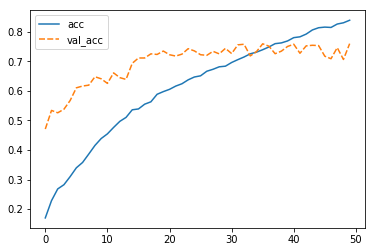

In [31]:
sns.lineplot(data=history[['acc','val_acc']])

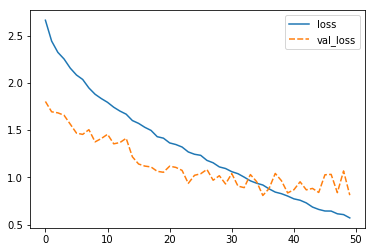

In [32]:
sns.lineplot(data=history[['loss','val_loss']])

In terms of loss and accuracy, it seems that both training accuracy and loss have had consistant improvment whereas the validation loss and accuracy seems to be staggering in 70%~75% accuracy range.

In [0]:
y_test_predict = model.predict([X_test_image,X_test_meta])

[[0.5        0.14285714 0.14285714 0.         0.10714286 0.07142857
  0.03571429]
 [0.23741007 0.47482014 0.07913669 0.05035971 0.05035971 0.09352518
  0.01438849]
 [0.0880829  0.06217617 0.48186528 0.02072539 0.15025907 0.19689119
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.04109589 0.06164384 0.14383562 0.01369863 0.49315068 0.23287671
  0.01369863]
 [0.00677966 0.00881356 0.05355932 0.0020339  0.06847458 0.85830508
  0.0020339 ]
 [0.         0.13636364 0.09090909 0.09090909 0.09090909 0.13636364
  0.45454545]]


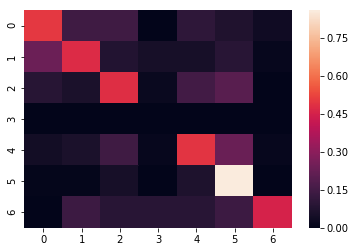

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_predict.argmax(axis=1),y_test.argmax(axis=1))
scaler = cm.sum(axis=1)[:, np.newaxis]
#prevent div by 0 error
for i in range(len(scaler)):
  if scaler[i] == 0:
    scaler[i] = 1
#scale the confusion matrix
cm = cm.astype('float') / scaler
print(cm)
sns.heatmap(cm)

From the seaborn heatmap of the confusion matrix, it looks like that our model is very accruate with 'nv' type skin cancer (index 5) and the model produced no predictions for 'df' type skin cancer. Also, we seem to have issue with wrongly classifying other labels with 'nv' type. The other lables seems to be somewhat well-classified. However, the uneven proportional of labels seems to be causing the issue with 'nv' and 'df' type labels.

### Methods for improvement 
1. Oversampling or Undersampling for even distirubtion of labels
2. Increase dropout rate for further regularization (loss graph indicates overfitting)
3. Add L2 regularization for DNN part for regularization as well
4. Hyperparameter tuning (since the model is not tuned)
5. Adding synthetic features: bucketize age into different age groups / dominant color of the image